## Module_3_2

Зафиксируем нулевые сиды.

In [19]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [20]:
import sklearn.datasets # Встроенный датафрейм wine
wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

In [21]:
import pandas as pd

pd.DataFrame(wine.data).head() # Вот так выглядит этот датафрейм

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


Итак, здесь мы импортируем функцию train_test_split, которая возвращает тренировочную и тестовую выборку, а также тренировочные и тестовые зависимые переменные. Для простоты возьмем только первые две колонки в данных.

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2], # Взяли первые две колонки в данных
    wine.target, # Указали зависимую (целевую) переменную
    test_size=0.3, # Сказали, что тестовая выборка должна составлять 0.3
    shuffle=True) # Перемешаем случайным образом разсплитенные данные (на самом деле, не случайно, ведь сид = 0)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

Создадим сеть.

In [41]:
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
    
wine_net = WineNet(5)

Подгрузим функцию потерь CE.

Также поставим оптимайзер, где градиентный спуск Adam, а lr = 0.001.

In [42]:
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(wine_net.parameters(), 
                             lr=1.0e-3)

Ознакомимся с функцией permutation.

In [28]:
np.random.permutation(5)

array([2, 0, 1, 4, 3])

Итак, теперь приступим к обучению.

Здесь мы бегаем по каждой эпохе, затем случайно выбираем порядок (order). Теперь тренируемся на каждом батче и по дороге оптимизируем наши параметры градиентным спуском. То есть при прохождении одной эпохи мы успеваем учиться
```
(len(X_train) - 1) // batch_size + 1 - раз

```
Здесь также можно печатать accuracy после каждых 100 итераций, чтобы нагляднее видеть, как обучается наша сеть.

In [43]:
batch_size = 10

for epoch in range(5000): 
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = wine_net.forward(x_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    if epoch % 100 == 0:
        test_preds = wine_net.forward(X_test)
        test_preds = test_preds.argmax(dim=1)
        # print((test_preds == y_test).float().mean())

Визуализируем, как хорошо происходит наша кластеризация. Здесь точки - train датасет, а заполненные области - это классификация сети.

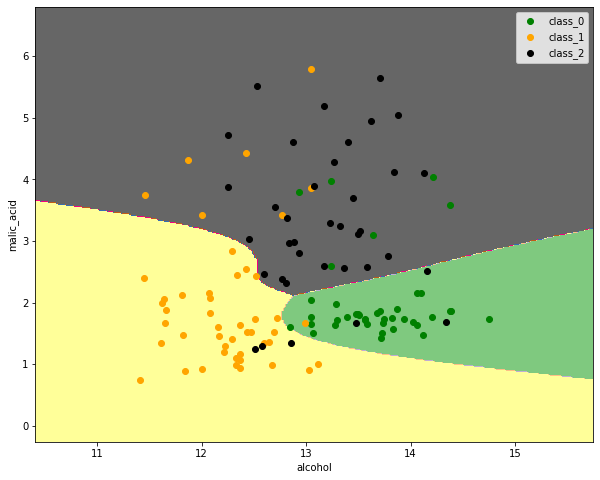

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0], 
                X_train[indexes, 1], 
                c=color, 
                label=wine.target_names[i],
                cmap='Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()